In [1]:
from IPython.display import display, Image, clear_output

# Comprehensive Lipidome Automation Workflow (CLAW)

Welcome to CLAW, a tool designed to facilitate and optimize the processing of lipidomic MRM data. This Jupyter notebook encapsulates a suite of tools that streamline the various stages of lipidomics data analysis.

Our toolset enables users to efficiently process MRM data files in the mzML format. Upload a file and CLAW will parse the data into a structured Pandas dataframe. This dataframe includes critical information like sample_ID, MRM transition, and signal intensity. Furthermore, our tool aligns each MRM transition with a default or custom lipid_database for accurate and swift annotation.

Moreover, CLAW is equipped with an OzESI option, a tool to elucidate the double bond location in lipid isomers. This feature allows users to input OzESI data and pinpoint the precise location of double bonds in isomeric lipids. Users have the flexibility to select which double bond locations they want to analyze. Following this, CLAW autonomously predicts potential m/z values and cross-references these predictions with sample data, ensuring a comprehensive and meticulous analysis.

With automation at its core, CLAW eliminates the need for manual data processing, significantly reducing time expenditure. It is a robust and invaluable tool for handling large volumes of lipid MRM data, accelerating scientific discovery in the field of lipidomics.

In [2]:
#Import all the necessary python libraries
import pymzml
import csv
import os
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json
from scipy.integrate import trapz

#Import all the necessary CLAW libraries
import create_directory
import CLAW
import matplotlib.pyplot as plt
import warnings

import re
from sklearn.mixture import GaussianMixture

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Directory and File Management
For structured data management and efficient workflow, the system first ensures the presence of an output directory. If such a directory already exists you can skip this step.

In [3]:
# # Create the output directory. If it already exists you can skip this step.
# create_directory.create_project_folder()


The name of the project is defined next. This is important as the created directory will bear this name, allowing users to manage and identify their data with ease.

After the mzML files are uploaded to the designated mzML folder, the next block of code segregates these files based on their characteristics. More specifically, it filters the files and transfers them to respective folders named 'o3on' and 'o2only'.

In [4]:
name_of_project = 'FaceFats'
#After you load mzml files to mzml folder. this will filter the files and move them to o3on and o2only folders
create_directory.filter_o3mzml_files(name_of_project)

One or both of the destination directories 'Projects/FaceFats/o3on' and 'Projects/FaceFats/o2only' do not exist.


## Pre-Parsing Setup
The following block of code takes the preset variable values and uses them to parse the mzML files. The parsed data, including the sample ID, MRM transitions, and intensities, is stored in a pandas dataframe for easy manipulation and analysis.

The function CLAW.parsing_mzml_to_df takes several arguments. data_base_name_location is the location of the lipid database that contains information on lipid classes, fatty acid chains, and their corresponding MRM transitions. Project_Folder_data is the location of the mzML files for the samples to be analyzed. tolerance defines the acceptable range of deviation for the MRM transitions when matching them with the lipid database. The argument remove_std is a boolean that, when True, indicates to remove the MRM transitions that correspond to standards (internal or external) present in the samples.

The function outputs a pandas dataframe (df) where each row corresponds to an MRM transition detected in a sample, and columns include the sample ID, MRM transition, and intensity of the transition, among other values.

In [5]:
# Set default values
data_base_name_location = 'lipid_database/Lipid_Database.xlsx'
Project = './Projects/'
Project_Name = 'FaceFats'
Project_Folder_data = Project + Project_Name + '/mzml_liver_OzON/'
Project_results = Project + Project_Name + '/results/'
file_name_to_save = 'Liver_OzON'
tolerance = 0.3
remove_std = True
save_data = True

# Call pre_parsing_setup to initialize the variables
data_base_name_location, Project_Folder_data, Project_results, file_name_to_save, tolerance, remove_std, save_data = CLAW.pre_parsing_setup(data_base_name_location,
 Project, 
 Project_Name, 
 Project_Folder_data,
 Project_results, 
 file_name_to_save, 
 tolerance, 
 remove_std,
 save_data)


data_base_name_location: lipid_database/Lipid_Database.xlsx
Project: ./Projects/
Project_Name: FaceFats
Project_Folder_data: ./Projects/FaceFats/mzml_liver_OzON/
Project_results: ./Projects/FaceFats/results/
file_name_to_save: Liver_OzON
tolerance: 0.3
remove_std: True
save_data: True


Define the master dataframes where the data will be stored during the parsing step.

In [6]:
time_and_intensity_df, master_df, OzESI_time_df = CLAW.create_analysis_dataframes()

## CLAW.full_parse()
In this code, the `CLAW.full_parse()` function is used to analyze the MRM data. It takes several parameters like the location of the lipid database, paths to the data and results folders, the name of the result files, and the tolerance for MRM transitions matching. The function returns two dataframes: `df_matched` that contains information about each detected lipid species and their corresponding MRM transitions, and `OzESI_time_df` which captures data related to OzESI-MS scans, including potential double bond locations of lipids. If `remove_std` is `True`, it removes MRM transitions related to standards from the dataframe, and if `save_data` is `True`, the dataframe is saved as a .csv file in the specified results folder.

In [7]:
# Use the initialized variables as arguments to full_parse
df_MRM, df_OzESI = CLAW.full_parse(data_base_name_location, 
                                               Project_Folder_data, 
                                               Project_results, 
                                               file_name_to_save, 
                                               tolerance, 
                                               remove_std=True, 
                                               save_data=False,
                                               batch_processing=True,
                                               plot_chromatogram=False)

/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Parent_Ion'] = np.round(lipid_MRM_data['Parent_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lipid_MRM_data['Product_Ion'] = np.round(lipid_MRM_data['Product_Ion'], 1)
/home/iyer95/CLAW/CLAW/lipid_platform/CLAW.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_DOD73_M2_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD131_M1_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD131_M2_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD131_M4_5xFAD_liver_O3on_01.mzML

Finished parsing mzML file: ./Projects/FaceFats/mzml_liver_OzON/12012023_FAD173_M1_5xFAD_liver_O3on_01.mzML

Finished parsing all mzML files



In [8]:
df_MRM.head(None)

,Class,Intensity,Lipid,Parent_Ion,Product_Ion,Sample_ID,Transition
0,NaN,23873.981735,NaN,584.4,437.3,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
1,NaN,30013.202080,NaN,612.4,437.3,12012023_DOD73_M2_5xFAD_liver_O3on_01,612.4 -> 437.3
2,NaN,27567.021954,NaN,622.5,503.4,12012023_DOD73_M2_5xFAD_liver_O3on_01,622.5 -> 503.4
3,NaN,30535.462173,NaN,624.5,505.4,12012023_DOD73_M2_5xFAD_liver_O3on_01,624.5 -> 505.4
4,NaN,81457.065533,NaN,626.5,437.3,12012023_DOD73_M2_5xFAD_liver_O3on_01,626.5 -> 437.3
...,...,...,...,...,...,...,...
745,TAG,233716.696194,"[TG(57:9),TG(56:2)]_FA18:1",932.9,633.6,12012023_FAD173_M1_5xFAD_liver_O3on_01,932.9 -> 633.6
746,TAG,49685.523727,"[TG(58:7),TG(57:0)]_FA18:1",950.9,651.6,12012023_FAD173_M1_5xFAD_liver_O3on_01,950.9 -> 651.6
747,TAG,34257.062469,"[TG(59:13),TG(58:6)]_FA18:1",952.8,653.5,12012023_FAD173_M1_5xFAD_liver_O3on_01,952.8 -> 653.5
748,TAG,40613.842754,"[TG(59:12),TG(58:5)]_FA18:1",954.8,655.5,12012023_FAD173_M1_5xFAD_liver_O3on_01,954.8 -> 655.5


In [9]:
df_OzESI.head(None)
# df_OzESI.to_csv('FF_OzOFF_full.csv')
# df_OzESI.to_excel('FaceFatsOzdf.xlsx')

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,584.4,437.3,0.044183,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
1,NaN,584.4,437.3,0.088567,41.120003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
2,NaN,584.4,437.3,0.132967,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
3,NaN,584.4,437.3,0.177367,41.060001,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
4,NaN,584.4,437.3,0.221783,41.100002,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
...,...,...,...,...,...,...,...
422241,NaN,956.9,657.6,24.779117,41.080002,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422242,NaN,956.9,657.6,24.823533,40.980003,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422243,NaN,956.9,657.6,24.867933,40.980003,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422244,NaN,956.9,657.6,24.912333,40.960003,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6


The `read_mrm_list()` function is first invoked to read the MRM database from the specified file location and return it as a pandas DataFrame `mrm_database`. Subsequently, the `match_lipids_parser()` function is called to match the detected lipids from the `OzESI_time_df` DataFrame, obtained from the OzESI-MS scans, with the known lipids in the `mrm_database` based on the MRM transitions within the specified `tolerance`. The result is saved in the `df_oz_matched` DataFrame, which now contains matched lipid species from the OzESI-MS data.

In [10]:
d1 = df_OzESI.iloc[:,1:9]

# Assuming d1 is your DataFrame

# Define the retention time range as a tuple (lower_bound, upper_bound)
retention_time_range = (9.5, 21.5)  # Replace with your specific range values

# Filter the DataFrame to keep only rows where Retention_Time is within the specified range
d1a = d1[(d1['Retention_Time'] >= retention_time_range[0]) & (d1['Retention_Time'] <= retention_time_range[1])]

# # Now, filtered_d1 contains only the rows from d1 where Retention_Time is within the specified range
# filtered_d1.to_csv('filtered_d1_FF_OzON_Liver.csv')
d1a

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
213,584.4,437.3,9.502800,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
214,584.4,437.3,9.547217,41.140003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
215,584.4,437.3,9.591617,41.000004,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
216,584.4,437.3,9.636017,40.960003,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
217,584.4,437.3,9.680433,41.040005,12012023_DOD73_M2_5xFAD_liver_O3on_01,584.4 -> 437.3
...,...,...,...,...,...,...
422163,956.9,657.6,21.315367,41.180004,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422164,956.9,657.6,21.359783,41.060001,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422165,956.9,657.6,21.404183,41.240002,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6
422166,956.9,657.6,21.448600,41.240002,12012023_FAD173_M1_5xFAD_liver_O3on_01,956.9 -> 657.6


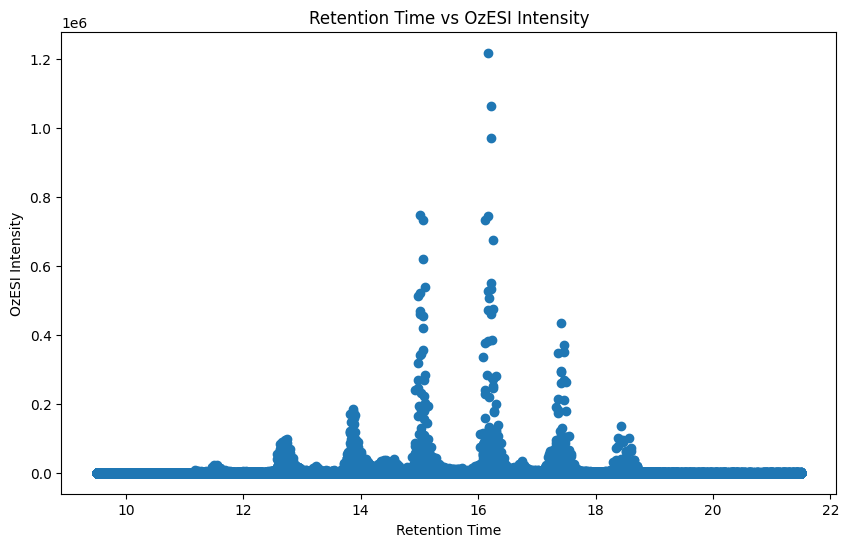

In [11]:


# Assuming clustered_data is your DataFrame with the necessary data

# Plotting the Intensity vs Retention Time
plt.figure(figsize=(10, 6))
plt.scatter(d1a['Retention_Time'], d1a['OzESI_Intensity'])

# Adding labels and title to the plot
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity')

# Displaying the plot
plt.show()


Correct RTs add DB position based on correct RT

In [12]:
Correct_RT_directory = 'tools/RT/'
#MRM CORRECT RT DF
df_MRM_RT_correct = pd.read_csv(Correct_RT_directory + 'FF_MRM_CorrectRT_Liver_12dec23_v2.csv') #correct MRM RT
# df_MRM_RT_correct['Retention_Time'] = df_MRM_RT_correct['Average_Retention_Time']

# List of new column names based on db_pos_list
db_column_names = []
db_pos_list = [7, 9, 10, 12]


df_DB_aldehyde = pd.DataFrame(columns=['DB_Position','Aldehyde_Ion'])

# Loop through the range of DB_Position values to calculate the corresponding Aldehyde_Ion values
for position in range(3, 21):
    df_DB_aldehyde.loc[position, 'DB_Position'] = position
    df_DB_aldehyde.loc[position, 'Aldehyde_Ion'] = 26 + (14 * (position-3))

for number in db_pos_list:
    db_column_names.append(f'n-{number}')

# Create an empty DataFrame with initial columns
df_db_pos = pd.DataFrame(columns=['Lipid', 'Retention_Time', 'Parent_Ion','Product_Ion'])

# Append new column names to the DataFrame
for column_name in db_column_names:
    df_db_pos[column_name] = pd.NA  # Initialize the new columns with NA

# df_DB_aldehyde #aldehyde ion values


#append df_MRM_RT_correct to df_db_pos
df_db_pos = df_db_pos.append(df_MRM_RT_correct, ignore_index=True)


# Loop through the specified db_pos_list
for ozesi_position in db_pos_list:
    # Retrieve the corresponding Aldehyde_Ion value for the current DB_Position
    aldehyde_ion = df_DB_aldehyde.loc[df_DB_aldehyde["DB_Position"] == ozesi_position, "Aldehyde_Ion"].values[0]

    # Calculate and store the n-i value for the current OzESI position
    df_db_pos["n-{}".format(ozesi_position)] = df_db_pos["Parent_Ion"] - aldehyde_ion


# df_db_pos.to_csv('df_db_pos.csv')
# df_MRM_RT_correct  #correct MRM RT
#drop Average_Retention_Time column from df db pos
df_db_pos  #empty df with n-7, n-9, n-10, n-12 columns


# # Function to remove the first TG if there are two TGs
# def remove_first_tg(lipid):
#     tg_parts = lipid.split(',')
#     if len(tg_parts) > 1:
#         return '[' + tg_parts[1]
#     else:
#         return lipid
    
# df_db_pos['Lipid'] = df_db_pos['Lipid'].apply(remove_first_tg)
    
# Function to determine the value for the FAC column
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None  # or some other default value

# Apply the function to the Lipid column to create the FAC column
df_db_pos['FAC'] = df_db_pos['Lipid'].apply(determine_fac)

#### sort df_db_pos
# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
df_db_pos['TG'] = df_db_pos['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell
    
# Function to remove TG(##:0) patterns from the Lipid string
def remove_tg_zero(lipid):
    # Pattern to match TG(##:0)
    pattern = r'TG\(\d+:0\)'
    # Remove TG(##:0) patterns
    new_lipid = re.sub(pattern, '', lipid)
    # Remove any extra commas and spaces left after removal
    new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
    return new_lipid

df_db_pos['Lipid'] = df_db_pos['Lipid'].apply(remove_tg_zero)
    
df_db_pos['TG'] = df_db_pos['TG'].apply(sort_tg_values)
#sort by FAC then TG
df_db_pos.sort_values(by=['FAC', 'TG'], inplace=True)
df_db_pos


,Lipid,Retention_Time,Parent_Ion,Product_Ion,n-7,n-9,n-10,n-12,FAC,TG
1,[TG(52:5)]_FA16:1,12.75,870.8,599.5,788.8,760.8,746.8,718.8,FA16:1,TG(52:5)
6,"[TG(55:11),TG(54:4)]_FA16:1",15.01,900.8,629.5,818.8,790.8,776.8,748.8,FA16:1,"TG(54:4), TG(55:11)"
13,"[TG(56:7),]_FA16:1",13.15,922.9,651.6,840.9,812.9,798.9,770.9,FA16:1,"TG(55:0), TG(56:7)"
0,[TG(50:3)]_FA18:1,14.00,846.8,547.5,764.8,736.8,722.8,694.8,FA18:1,TG(50:3)
2,"[TG(52:7),]_FA18:1",17.06,866.8,567.5,784.8,756.8,742.8,714.8,FA18:1,"TG(51:0), TG(52:7)"
8,"[TG(55:8),TG(54:1)]_FA18:1",18.61,906.8,607.5,824.8,796.8,782.8,754.8,FA18:1,"TG(54:1), TG(55:8)"
9,"[TG(55:9),TG(54:2)]_FA18:1",17.50,904.8,605.5,822.8,794.8,780.8,752.8,FA18:1,"TG(54:2), TG(55:9)"
5,"[TG(55:10),TG(54:3)]_FA18:1",16.26,902.8,603.5,820.8,792.8,778.8,750.8,FA18:1,"TG(54:3), TG(55:10)"
7,"[TG(55:11),TG(54:4)]_FA18:1",15.10,900.8,601.5,818.8,790.8,776.8,748.8,FA18:1,"TG(54:4), TG(55:11)"
3,[TG(54:5)]_FA18:1,13.91,898.8,599.5,816.8,788.8,774.8,746.8,FA18:1,TG(54:5)


Filter through filtered_d1 based on matched OzOFF lipids df_db_pos for n-7 and n-9 values

In [13]:
# Assuming df_db_pos and filtered_d1 are your DataFrames

tolerance = 0.3
retention_time_tolerance = 1.0  # Adjust this value as needed

# Re-initializing an empty DataFrame for filtered_d2
d2 = pd.DataFrame()

# Iterating through df_db_pos
for index, row in df_db_pos.iterrows():
    ground_truth_retention_time = row['Retention_Time']  # Ground truth retention time
    product_ion = row['Product_Ion']
    parent_ion_n7 = row['n-7']
    parent_ion_n9 = row['n-9']
    parent_ion_n10 = row['n-10']
    parent_ion_n12 = row['n-12']
    lipid_name = row['Lipid']  # Extracting Lipid name from df_db_pos

    # Defining the retention time window based on ground truth
    lower_bound_time = ground_truth_retention_time - retention_time_tolerance -0.1
    upper_bound_time = ground_truth_retention_time + retention_time_tolerance

    # Defining the tolerance for Parent and Product ions
    lower_bound_ion = product_ion - tolerance
    upper_bound_ion = product_ion + tolerance

    # Filtering filtered_d1 within the specified window and matching ions with tolerance
    matches = d1a[(d1a['Retention_Time'] >= lower_bound_time) & 
                        (d1a['Retention_Time'] <= upper_bound_time) &
                        (d1a['OzESI_Intensity'] >= 5) &
                        (d1a['Product_Ion'] >= lower_bound_ion) &
                        (d1a['Product_Ion'] <= upper_bound_ion)]

    # Adding 'db' and 'Lipid' columns based on the tolerance matching
    matches['db'] = ''
    matches['Lipid'] = lipid_name  # Adding the Lipid name to all matches
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n7 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n7 + tolerance), 'db'] = 'n-7'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n9 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n9 + tolerance), 'db'] = 'n-9'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n10 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n10 + tolerance), 'db'] = 'n-10'
    matches.loc[(matches['Parent_Ion'] >= parent_ion_n12 - tolerance) & 
                (matches['Parent_Ion'] <= parent_ion_n12 + tolerance), 'db'] = 'n-12'

    # Append the matching rows to filtered_d2
    d2 = d2.append(matches)

# Resetting the index of the new DataFrame
d2 = d2.reset_index(drop=True)

# Display the first few rows of the new DataFrame
d2


/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid
0,718.6,599.5,11.674000,51.320004,12012023_DOD73_M2_5xFAD_liver_O3on_01,718.6 -> 599.5,n-12,[TG(52:5)]_FA16:1
1,718.6,599.5,11.718417,61.500004,12012023_DOD73_M2_5xFAD_liver_O3on_01,718.6 -> 599.5,n-12,[TG(52:5)]_FA16:1
2,718.6,599.5,11.762817,40.980003,12012023_DOD73_M2_5xFAD_liver_O3on_01,718.6 -> 599.5,n-12,[TG(52:5)]_FA16:1
3,718.6,599.5,11.807217,106.600006,12012023_DOD73_M2_5xFAD_liver_O3on_01,718.6 -> 599.5,n-12,[TG(52:5)]_FA16:1
4,718.6,599.5,11.851633,73.880005,12012023_DOD73_M2_5xFAD_liver_O3on_01,718.6 -> 599.5,n-12,[TG(52:5)]_FA16:1
...,...,...,...,...,...,...,...,...
34350,952.8,653.5,16.386817,41.180004,12012023_FAD173_M1_5xFAD_liver_O3on_01,952.8 -> 653.5,,"[TG(59:13),TG(58:6)]_FA18:1"
34351,952.8,653.5,16.431217,41.160004,12012023_FAD173_M1_5xFAD_liver_O3on_01,952.8 -> 653.5,,"[TG(59:13),TG(58:6)]_FA18:1"
34352,952.8,653.5,16.475633,41.200005,12012023_FAD173_M1_5xFAD_liver_O3on_01,952.8 -> 653.5,,"[TG(59:13),TG(58:6)]_FA18:1"
34353,952.8,653.5,16.520033,41.360004,12012023_FAD173_M1_5xFAD_liver_O3on_01,952.8 -> 653.5,,"[TG(59:13),TG(58:6)]_FA18:1"


Check specific transition RT for validate RT

In [14]:
# Assuming filtered_d2 is already created and contains the 'db' column

# Filter to get only the rows where 'db' is 'n-7'
n7_values = d2[d2['db'] == 'n-7']

# Filter to get only the rows with specific transition: Parent_Ion 788.7 to Product_Ion 599.5
specific_transition = n7_values[(n7_values['Parent_Ion'] == 790.7) & (n7_values['Product_Ion'] == 573.6)]

specific_transition


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid


Filter for only db values

In [15]:
# Creating filtered_d3 from filtered_d2
d3 = d2.copy()

# Dropping rows where 'db' column is blank
d3 = d3[d3['db'] != '']

# Alternatively, you can use:
# filtered_d3 = filtered_d3.dropna(subset=['db'])

d3


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid
0,718.6,599.5,11.674000,51.320004,12012023_DOD73_M2_5xFAD_liver_O3on_01,718.6 -> 599.5,n-12,[TG(52:5)]_FA16:1
1,718.6,599.5,11.718417,61.500004,12012023_DOD73_M2_5xFAD_liver_O3on_01,718.6 -> 599.5,n-12,[TG(52:5)]_FA16:1
2,718.6,599.5,11.762817,40.980003,12012023_DOD73_M2_5xFAD_liver_O3on_01,718.6 -> 599.5,n-12,[TG(52:5)]_FA16:1
3,718.6,599.5,11.807217,106.600006,12012023_DOD73_M2_5xFAD_liver_O3on_01,718.6 -> 599.5,n-12,[TG(52:5)]_FA16:1
4,718.6,599.5,11.851633,73.880005,12012023_DOD73_M2_5xFAD_liver_O3on_01,718.6 -> 599.5,n-12,[TG(52:5)]_FA16:1
...,...,...,...,...,...,...,...,...
34303,870.7,653.5,16.393767,115.780006,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1"
34304,870.7,653.5,16.438167,41.140003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1"
34305,870.7,653.5,16.482567,40.840004,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1"
34306,870.7,653.5,16.526983,41.120003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1"


# GMM

In [16]:


# Assuming filtered_d2 is your DataFrame
d4 = pd.DataFrame()  # Initialize an empty DataFrame to store clustered results

# Iterate over each group of Parent_Ion and Product_Ion
for (parent_ion, product_ion, db), group in d3.groupby(['Parent_Ion', 'Product_Ion','db']):
    # Calculate 1% below the maximum 'OzESI_Intensity'
    max_intensity = group['OzESI_Intensity'].max()
    cutoff_intensity = max_intensity * 0.00005

    # Apply the filters
    filtered_group = group[(group['OzESI_Intensity'] >= cutoff_intensity) & (group['OzESI_Intensity'] > 0)]

    # Check if the filtered group is empty or has less than 2 samples
    if filtered_group.empty or len(filtered_group) < 2:
        continue

    # Reshape the 'Retention_Time' data for GMM
    retention_times = filtered_group[['Retention_Time']].values

    # Apply GMM clustering to this specific ion pair group
    # Note: Adjust the number of components (n_components) as needed
    gmm = GaussianMixture(n_components=3, covariance_type='full').fit(retention_times)

    # Get the cluster labels
    labels = gmm.predict(retention_times)

    # Add the cluster labels to the filtered group
    filtered_group['Cluster_Label'] = labels

    # Append the clustered group to the results DataFrame
    d4 = pd.concat([d4, filtered_group])

# The resulting DataFrame, clustered_data, now contains separately clustered data for each ion pair
d4


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label
7095,694.6,547.5,12.918583,231.780014,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1
7096,694.6,547.5,12.962983,354.560028,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1
7097,694.6,547.5,13.007400,305.760010,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1
7098,694.6,547.5,13.051800,70.180008,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1
7099,694.6,547.5,13.096217,211.200012,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1
...,...,...,...,...,...,...,...,...,...
31938,874.8,657.6,18.035917,41.020004,12012023_FAD173_M1_5xFAD_liver_O3on_01,874.8 -> 657.6,n-7,"[TG(59:11),TG(58:4)]_FA18:1",1
31939,874.8,657.6,18.080317,41.220001,12012023_FAD173_M1_5xFAD_liver_O3on_01,874.8 -> 657.6,n-7,"[TG(59:11),TG(58:4)]_FA18:1",1
31940,874.8,657.6,18.124717,224.260010,12012023_FAD173_M1_5xFAD_liver_O3on_01,874.8 -> 657.6,n-7,"[TG(59:11),TG(58:4)]_FA18:1",1
31941,874.8,657.6,18.169133,178.900009,12012023_FAD173_M1_5xFAD_liver_O3on_01,874.8 -> 657.6,n-7,"[TG(59:11),TG(58:4)]_FA18:1",1


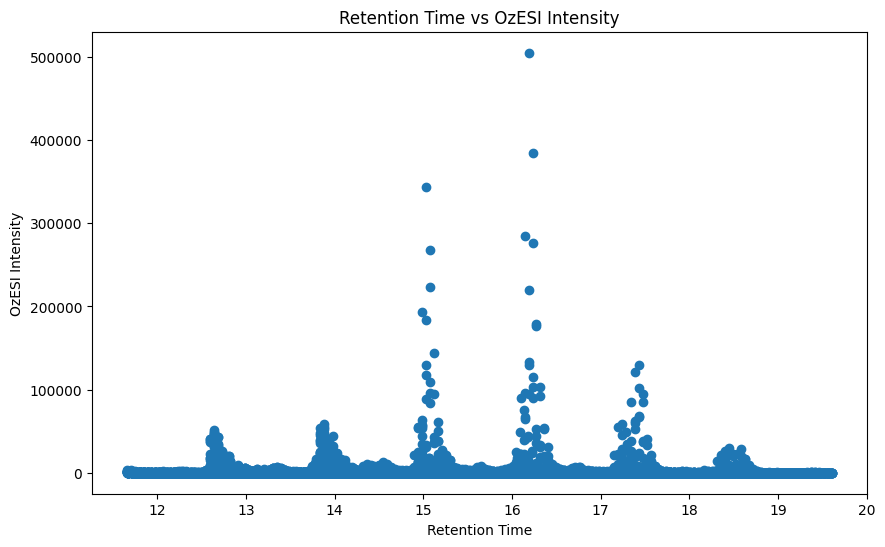

In [17]:


# Assuming clustered_data is your DataFrame with the necessary data

# Plotting the Intensity vs Retention Time
plt.figure(figsize=(10, 6))
plt.scatter(d4['Retention_Time'], d4['OzESI_Intensity'])

# Adding labels and title to the plot
plt.xlabel('Retention Time')
plt.ylabel('OzESI Intensity')
plt.title('Retention Time vs OzESI Intensity')

# Displaying the plot
plt.show()


# Determine Biology and Genotype

In [18]:
# Function to determine the value for the Biology and Genotype column
def extract_biology(sample_id):
    for term in ["liver", "cortex", "cereb", "hippo", "dienc"]:
        if term in sample_id.lower():
            return term
    return None

# Apply the function to the Sample_ID column to create the Biology and Genotype column
d4['Biology'] = d4['Sample_ID'].apply(extract_biology)
d4['Genotype'] = d4['Sample_ID'].apply(lambda x: '5xFAD' if 'WT' not in x else 'WT')
d4

# # Function to remove the first TG if there are two TGs
# def remove_first_tg(lipid):
#     tg_parts = lipid.split(',')
#     if len(tg_parts) > 1:
#         return '[' + tg_parts[1]
#     else:
#         return lipid
    
# Function to determine the value for the FAC column
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None  # or some other default value

# Apply the function to the Lipid column to create the FAC column
d4['FAC'] = d4['Lipid'].apply(determine_fac)



# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
d4['TG'] = d4['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell

# Function to remove TG(##:0) patterns from the Lipid string
def remove_tg_zero(lipid):
    # Pattern to match TG(##:0)
    pattern = r'TG\(\d+:0\)'
    # Remove TG(##:0) patterns
    new_lipid = re.sub(pattern, '', lipid)
    # Remove any extra commas and spaces left after removal
    new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
    return new_lipid


d4['Lipid'] = d4['Lipid'].apply(remove_tg_zero)
# Apply the function to the TG column
d4['TG'] = d4['TG'].apply(sort_tg_values)
d4 = d4.sort_values(by=['FAC', 'TG'])



# Sorting by 'Biology and Genotype' and then by 'Lipid'
d4 = d4.sort_values(by=['Biology','Genotype', 'Lipid'])

grouped_cluster_data = d4.groupby(['Lipid','db','Biology','Genotype','Transition','Sample_ID'])
#add group number to each to a new column called Group
d4['Group'] = grouped_cluster_data.ngroup()
d4
d5= d4.copy()  # Create a copy of the clustered_data DataFrame
#print transition 870.8 -> 788.8
d5


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group
7095,694.6,547.5,12.918583,231.780014,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5
7096,694.6,547.5,12.962983,354.560028,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5
7097,694.6,547.5,13.007400,305.760010,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5
7098,694.6,547.5,13.051800,70.180008,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5
7099,694.6,547.5,13.096217,211.200012,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34303,870.7,653.5,16.393767,115.780006,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454
34304,870.7,653.5,16.438167,41.140003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454
34305,870.7,653.5,16.482567,40.840004,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454
34306,870.7,653.5,16.526983,41.120003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454


# Find max intensity

In [19]:
d6 = d5.copy()
# Group by 'Group' and 'Cluster_Label' and find the maximum 'OzESI_Intensity' for each group
max_intensity_group = d5.groupby(['Group', 'Cluster_Label'])['OzESI_Intensity'].max().reset_index()

# Rename the column to 'Max_Intensity'
max_intensity_group = max_intensity_group.rename(columns={'OzESI_Intensity': 'Max_Intensity'})

# Merge the maximum intensity data back into the original DataFrame
d6 = d6.merge(max_intensity_group, on=['Group', 'Cluster_Label'])
#round max intensity to 0 decimal places
d6['Max_Intensity'] = d6['Max_Intensity'].round(0)
# Display the DataFrame
d6



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity
0,694.6,547.5,12.918583,231.780014,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0
1,694.6,547.5,12.962983,354.560028,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0
2,694.6,547.5,13.007400,305.760010,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0
3,694.6,547.5,13.051800,70.180008,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0
4,694.6,547.5,13.096217,211.200012,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24690,870.7,653.5,16.393767,115.780006,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0
24691,870.7,653.5,16.438167,41.140003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0
24692,870.7,653.5,16.482567,40.840004,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0
24693,870.7,653.5,16.526983,41.120003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0


# Match cluster to ground truth RT

In [20]:


# Assuming d6 DataFrame is already defined
d7 = d6.copy()

# Adding Cluster_RT column to d7 using Max_Intensity values
d7['Cluster_RT'] = d7.groupby(['Lipid', 'Sample_ID', 'db'])['Max_Intensity'].transform('idxmax').map(d7['Retention_Time'])

# Rounding Cluster_RT to 2 decimal places
d7['Cluster_RT'] = d7['Cluster_RT'].round(2)



###########

# Assuming d8 is already defined
d8 = d7.copy()

# Create a mapping from Lipid to ground truth Retention_Time
ground_truth_rt = dict(zip(df_db_pos['Lipid'], df_db_pos['Retention_Time']))

# Calculate the distance to the ground truth for each row in d8
d8['distance_to_truth'] = d8.apply(lambda row: abs(row['Retention_Time'] - ground_truth_rt.get(row['Lipid'], np.nan)), axis=1)
d8

# # Filter out rows with NaN in 'distance_to_truth'
# d8_filtered = d8.dropna(subset=['distance_to_truth'])
# #print unique lipid in d5
# d8_filtered['Lipid'].unique()

# # Function to keep all rows of the group with the closest Cluster_Label to the ground truth
# def keep_group_with_closest_cluster(group):
#     idx_min_distance = group['distance_to_truth'].idxmin()
#     closest_cluster_label = group.loc[idx_min_distance, 'Cluster_Label']
#     return group[group['Cluster_Label'] == closest_cluster_label]

# # Apply the function to each group in the filtered DataFrame
# df_true = d8.groupby('Group').apply(keep_group_with_closest_cluster).reset_index(drop=True)

# # Displaying the updated DataFrame
# df_true

# d9 = df_true.copy()    
# d9




,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth
0,694.6,547.5,12.918583,231.780014,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,1.081417
1,694.6,547.5,12.962983,354.560028,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,1.037017
2,694.6,547.5,13.007400,305.760010,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,0.992600
3,694.6,547.5,13.051800,70.180008,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,0.948200
4,694.6,547.5,13.096217,211.200012,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,0.903783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24690,870.7,653.5,16.393767,115.780006,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0,15.91,0.803767
24691,870.7,653.5,16.438167,41.140003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0,15.91,0.848167
24692,870.7,653.5,16.482567,40.840004,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0,15.91,0.892567
24693,870.7,653.5,16.526983,41.120003,12012023_FAD173_M1_5xFAD_liver_O3on_01,870.7 -> 653.5,n-7,"[TG(59:13),TG(58:6)]_FA18:1",1,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",454,116.0,15.91,0.936983


# Keep Cluster with highest max intensity, remove other clusters

In [21]:
d10 = d8.copy()
# Step 1: Identify the Cluster_Label with the highest Max_Intensity for each Group
max_intensity_label_per_group = d10.groupby('Group').apply(lambda x: x['Cluster_Label'][x['Max_Intensity'].idxmax()])

# Step 2: Filter the original DataFrame
d10 = d10[d10.apply(lambda row: row['Cluster_Label'] == max_intensity_label_per_group[row['Group']], axis=1)]

# Filter out group-cluster pairs where the maximum intensity (Max_Intensity) is 500 or less
valid_pairs = d10[d10['Max_Intensity'] > 300]

# The resulting DataFrame, valid_pairs, now contains data for group-cluster pairs meeting the intensity criterion
d10 = valid_pairs

# Display the filtered DataFrame
d10



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth
0,694.6,547.5,12.918583,231.780014,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,1.081417
1,694.6,547.5,12.962983,354.560028,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,1.037017
2,694.6,547.5,13.007400,305.760010,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,0.992600
3,694.6,547.5,13.051800,70.180008,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,0.948200
4,694.6,547.5,13.096217,211.200012,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,0.903783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24440,842.7,653.5,15.731233,41.120003,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.141233
24441,842.7,653.5,15.775650,41.280003,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.185650
24442,842.7,653.5,15.820050,41.180004,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.230050
24443,842.7,653.5,15.864467,41.040005,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.274467


# Set Peak Boundaries using Peak Width at % of Peak Height

In [22]:
# Assuming d7 is already defined
d11 = d10.copy()

# Define the directory where you want to save the plots
save_directory = 'Projects/FaceFats/plots/peak_check/width/'
os.makedirs(save_directory, exist_ok=True)

# Setting parameters for peak finding
peak_width_fraction = 0.01
peak_width_fraction_large = 0.01
peak_width_intensity_threshold = 2000

# Function to calculate peak boundaries
def calculate_peak_boundaries(intensities, times, peak_max_index):
    peak_max_intensity = intensities[peak_max_index]
    if peak_max_intensity > peak_width_intensity_threshold:
        intensity_threshold = peak_max_intensity * peak_width_fraction_large
    else:
        intensity_threshold = peak_max_intensity * peak_width_fraction

    left_indices = np.where(intensities[:peak_max_index] < intensity_threshold)[0]
    right_indices = np.where(intensities[peak_max_index:] < intensity_threshold)[0] + peak_max_index

    peak_start = times[left_indices[-1]] if len(left_indices) > 0 else times[0]
    peak_end = times[right_indices[0]] if len(right_indices) > 0 else times[-1]

    return peak_start, peak_end

def plot_peak_and_boundaries(group_data, group, cluster_label, save_dir, peak_width_fraction=0.2):
    
    times = group_data['Retention_Time'].values
    intensities = group_data['OzESI_Intensity'].values
    peak_max_index = np.argmax(intensities)
    peak_max_intensity = intensities[peak_max_index]
    peak_start, peak_end = calculate_peak_boundaries(intensities, times, peak_max_index)

    # Extract additional information for the title
    lipid = group_data.iloc[0]['Lipid']
    biology = group_data.iloc[0]['Biology']
    genotype = group_data.iloc[0]['Genotype']
    db = group_data.iloc[0]['db']
    sample_id = group_data.iloc[0]['Sample_ID']

    # # Plotting
    # plt.figure(figsize=(10, 6))
    # plt.plot(times, intensities, label='Intensity')
    # plt.scatter(times[peak_max_index], intensities[peak_max_index], color='red', label='Peak', zorder=5)
    # if peak_max_intensity > peak_width_intensity_threshold:
    #     plt.axvline(peak_start, color='green', linestyle='--', label=f'Peak Start (Width at {peak_width_fraction_large*100:.0f}%)')
    #     plt.axvline(peak_end, color='blue', linestyle='--', label=f'Peak End (Width at {peak_width_fraction_large*100:.0f}%)')
    # else:
    #     plt.axvline(peak_start, color='green', linestyle='--', label=f'Peak Start (Width at {peak_width_fraction*100:.0f}%)')
    #     plt.axvline(peak_end, color='blue', linestyle='--', label=f'Peak End (Width at {peak_width_fraction*100:.0f}%)')
    # plt.xlabel('Retention Time')
    # plt.ylabel('OzESI Intensity')
    # plt.title(f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}')
    # plt.legend()

    # filename = f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}.png'
    # # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
    # # plt.show()
    # plt.close()

# Iterating over groups and clusters and plotting peaks
for (group, cluster_label), group_df in d11.groupby(['Group', 'Cluster_Label']):
    group_df_sorted = group_df.sort_values(by='Retention_Time')
    peak_max_index = np.argmax(group_df_sorted['OzESI_Intensity'].values)
    peak_start, peak_end = calculate_peak_boundaries(group_df_sorted['OzESI_Intensity'].values, 
                                                     group_df_sorted['Retention_Time'].values, 
                                                     peak_max_index)

    # Update d11 with peak boundaries
    d11.loc[(d11['Group'] == group) & (d11['Cluster_Label'] == cluster_label), 'RT_Start'] = peak_start.round(2)
    d11.loc[(d11['Group'] == group) & (d11['Cluster_Label'] == cluster_label), 'RT_End'] = peak_end.round(2)

    # Plot and save peak analysis with the correct peak_width_fraction
    plot_peak_and_boundaries(group_df_sorted, group, cluster_label, save_directory, peak_width_fraction)

# Now the plots will use the peak_width_fraction of 0.22 as intended

# Display the updated DataFrame
d11




,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End
0,694.6,547.5,12.918583,231.780014,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,1.081417,12.92,13.58
1,694.6,547.5,12.962983,354.560028,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,1.037017,12.92,13.58
2,694.6,547.5,13.007400,305.760010,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,0.992600,12.92,13.58
3,694.6,547.5,13.051800,70.180008,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,0.948200,12.92,13.58
4,694.6,547.5,13.096217,211.200012,12012023_DOD73_M2_5xFAD_liver_O3on_01,694.6 -> 547.5,n-12,[TG(50:3)]_FA18:1,1,liver,5xFAD,FA18:1,TG(50:3),5,355.0,12.92,0.903783,12.92,13.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24440,842.7,653.5,15.731233,41.120003,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.141233,15.24,15.91
24441,842.7,653.5,15.775650,41.280003,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.185650,15.24,15.91
24442,842.7,653.5,15.820050,41.180004,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.230050,15.24,15.91
24443,842.7,653.5,15.864467,41.040005,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.274467,15.24,15.91


# Adjust new RTs based off peak width % calc

In [23]:
d12 = d11.copy()
d12
# Initialize an empty DataFrame to store the filtered results
filtered_d9 = pd.DataFrame()

# Iterate over each group-cluster pair
for (group, cluster_label), group_df in d12.groupby(['Group', 'Cluster_Label']):
    # Get the RT_Start and RT_End values for the current group-cluster pair
    rt_start = group_df['RT_Start'].iloc[0]
    rt_end = group_df['RT_End'].iloc[0]

    # Filter the DataFrame for rows where Retention_Time is within the start and end window
    within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

    # Append the filtered data to the results DataFrame
    filtered_d9 = pd.concat([filtered_d9, within_window])

# Assign the filtered DataFrame back to d12
d12 = filtered_d9

# Display the filtered DataFrame
d12


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End
252,722.7,547.5,13.672017,40.880001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,13.63,0.327983,13.63,14.29
253,722.7,547.5,13.716417,41.060001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,13.63,0.283583,13.63,14.29
254,722.7,547.5,13.760833,41.200005,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,13.63,0.239167,13.63,14.29
255,722.7,547.5,13.805233,40.900002,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,13.63,0.194767,13.63,14.29
256,722.7,547.5,13.849650,142.640015,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,13.63,0.150350,13.63,14.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24440,842.7,653.5,15.731233,41.120003,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.141233,15.24,15.91
24441,842.7,653.5,15.775650,41.280003,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.185650,15.24,15.91
24442,842.7,653.5,15.820050,41.180004,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.230050,15.24,15.91
24443,842.7,653.5,15.864467,41.040005,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.274467,15.24,15.91


# Manually adjust RTs

In [24]:
d13 = d12.copy()
def Peak_Adjust(d13, adjust_specs):
    adjusted_df = d13.copy()

    for spec in adjust_specs:
        group = spec['group']
        start_left = spec.get('start_left', None)
        start_right = spec.get('start_right', None)

        group_mask = adjusted_df['Group'] == group

        if not adjusted_df[group_mask].empty:
            if start_left == 999:
                start_left = adjusted_df[group_mask]['RT_Start'].iloc[0]
            if start_right == 999:
                start_right = adjusted_df[group_mask]['RT_End'].iloc[0]

            for cluster_label in adjusted_df[group_mask]['Cluster_Label'].unique():
                mask = group_mask & (adjusted_df['Cluster_Label'] == cluster_label)

                adjusted_df.loc[mask, 'RT_Start'] = start_left
                adjusted_df.loc[mask, 'RT_End'] = start_right

                if start_left is not None:
                    adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(lower=start_left)
                if start_right is not None:
                    adjusted_df.loc[mask, 'Retention_Time'] = adjusted_df.loc[mask, 'Retention_Time'].clip(upper=start_right)

    return adjusted_df


# Define the Peak Retention Time Adjustments for each Group
adjust_specs = [
    #50:3
    {'group': 1, 'start_left': 13.88, 'start_right': 999},
    {'group': 0, 'start_left': 13.7, 'start_right': 14.05},
    #52:5 16:1 double check the 12.9 for theses later
    {'group': 41, 'start_left': 12.6, 'start_right': 999},
    {'group': 42, 'start_left': 12.6, 'start_right': 999},
    {'group': 40, 'start_left': 12.6, 'start_right': 13},
    {'group': 43, 'start_left': 12.6, 'start_right': 12.9},
    {'group': 44, 'start_left': 12.6, 'start_right': 12.9},
    #n12s 45-49
    {'group': 46, 'start_left': 12.6, 'start_right': 999},
    {'group': 47, 'start_left': 12.6, 'start_right': 999},
    {'group': 48, 'start_left': 12.6, 'start_right': 999},
    {'group': 49, 'start_left': 12.6, 'start_right': 999},
    #54:5
    {'group': 162, 'start_left': 13.68, 'start_right': 999},
    # 54:6 191 n7 has two peaks? do all 54:6 have two peaks?



]

d13 = Peak_Adjust(d13, adjust_specs)

# Display a portion of the adjusted DataFrame
d13



,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End
252,722.7,547.5,13.700000,40.880001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,13.63,0.327983,13.70,14.05
253,722.7,547.5,13.716417,41.060001,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,13.63,0.283583,13.70,14.05
254,722.7,547.5,13.760833,41.200005,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,13.63,0.239167,13.70,14.05
255,722.7,547.5,13.805233,40.900002,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,13.63,0.194767,13.70,14.05
256,722.7,547.5,13.849650,142.640015,12012023_DOD73_M2_5xFAD_liver_O3on_01,722.7 -> 547.5,n-10,[TG(50:3)]_FA18:1,2,liver,5xFAD,FA18:1,TG(50:3),0,354.0,13.63,0.150350,13.70,14.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24440,842.7,653.5,15.731233,41.120003,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.141233,15.24,15.91
24441,842.7,653.5,15.775650,41.280003,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.185650,15.24,15.91
24442,842.7,653.5,15.820050,41.180004,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.230050,15.24,15.91
24443,842.7,653.5,15.864467,41.040005,12012023_FAD173_M1_5xFAD_liver_O3on_01,842.7 -> 653.5,n-9,"[TG(59:13),TG(58:6)]_FA18:1",0,liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,15.24,0.274467,15.24,15.91


# Filter d9 df based on manually selected RT_Start and RT_End

In [25]:
d14 = d13.copy()  # Creating d14 DataFrame from the newly filtered d9

# Initialize an empty DataFrame to store the filtered results
filtered_d10 = pd.DataFrame()

# Iterate over each group-cluster pair
for (group, cluster_label), group_df in d14.groupby(['Group', 'Cluster_Label']):
    # Get the RT_Start and RT_End values for the current group-cluster pair
    rt_start = group_df['RT_Start'].iloc[0]
    rt_end = group_df['RT_End'].iloc[0]

    # Filter the DataFrame for rows where Retention_Time is within the start and end window
    within_window = group_df[(group_df['Retention_Time'] >= rt_start) & (group_df['Retention_Time'] <= rt_end)]

    # Append the filtered data to the results DataFrame
    filtered_d10 = pd.concat([filtered_d10, within_window])

# Assign the filtered DataFrame back to d14
d14 = filtered_d10
# Sort d14 DataFrame by 'Retention_Time'
d14= d14.sort_values(by='Retention_Time')

# Display the filtered DataFrame
d14


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End
1180,746.6,599.5,11.670783,1443.520142,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,11.67,1.079217,11.67,12.34
1274,746.6,599.5,11.670800,816.800049,12012023_FAD131_M1_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,5xFAD,FA16:1,TG(52:5),21,1623.0,11.67,1.079200,11.67,12.34
1368,746.6,599.5,11.670817,974.160095,12012023_FAD131_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,5xFAD,FA16:1,TG(52:5),22,1624.0,11.67,1.079183,11.67,12.34
1556,746.6,599.5,11.670833,323.400024,12012023_FAD173_M1_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,5xFAD,FA16:1,TG(52:5),24,926.0,11.67,1.079167,11.67,12.34
1196,746.6,599.5,11.671050,1272.740112,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,11.67,1.078950,11.67,12.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9842,824.7,607.5,18.887650,40.680004,12012023_FAD131_M2_5xFAD_liver_O3on_01,824.7 -> 607.5,n-7,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",172,1388.0,18.27,0.277650,18.27,18.93
9938,824.7,607.5,18.887667,41.020004,12012023_FAD173_M1_5xFAD_liver_O3on_01,824.7 -> 607.5,n-7,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",174,401.0,18.27,0.277667,18.27,18.93
9506,796.7,607.5,18.896167,100.780006,12012023_DOD73_M2_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",175,10666.0,18.23,0.286167,18.41,18.90
9554,796.7,607.5,18.896167,57.820004,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,18.23,0.286167,18.50,18.90


# Plot the manually adjusted RTs to confirm peaks are correct

In [26]:
# def plot_data(group_data, group, cluster_label, save_dir):
#     if group_data.empty:
#         print(f"No data available for Group {group}, Cluster {cluster_label}. Skipping plot.")
#         return

#     # Extracting data for plotting
#     times = group_data['Retention_Time'].values
#     intensities = group_data['OzESI_Intensity'].values

#     # Extract additional information for the title
#     lipid = group_data.iloc[0]['Lipid']
#     biology = group_data.iloc[0]['Biology']
#     genotype = group_data.iloc[0]['Genotype']
#     db = group_data.iloc[0]['db']
#     sample_id = group_data.iloc[0]['Sample_ID']

#     # Plotting
#     plt.figure(figsize=(10, 6))
#     plt.plot(times, intensities, label='Intensity')
#     plt.xlabel('Retention Time')
#     plt.ylabel('OzESI Intensity')
#     plt.title(f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}')
#     plt.legend()

#     # Save the plot
#     filename = f'{group}, {cluster_label}, {lipid}, {biology}, {genotype}, {sample_id}, {db}.png'
#     # plt.savefig(os.path.join(save_dir, filename), bbox_inches='tight')
#     plt.show()
#     plt.close()

# # Define the directory to save the plots
# save_directory = 'Projects/FaceFats/plots/peak_check/manual/'  # Replace with your directory path

# # Plotting for each group-cluster pair in d14
# for (group, cluster_label), group_df in d14.groupby(['Group', 'Cluster_Label']):
#     plot_data(group_df, group, cluster_label, save_directory)


# Calculate Area of peak

In [27]:
d15 = d14.copy()  # Creating d15 DataFrame from the newly filtered d10



# Create an empty DataFrame for storing the calculated areas
area_results = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area'])

# Group by 'Group' and 'Cluster_Label'
grouped_data = d15.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results DataFrame
    area_results = area_results.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area': area
    }, ignore_index=True)

# Merge the calculated areas back into the original DataFrame
d15 = pd.merge(d15, area_results, on=['Group', 'Cluster_Label'])

# Round the 'Area' to 0 decimal places
d15['Area'] = d15['Area'].round(0)
d15


,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,Genotype,FAC,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End,Area
0,746.6,599.5,11.670783,1443.520142,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,11.67,1.079217,11.67,12.34,133.0
1,746.6,599.5,11.671050,1272.740112,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,11.67,1.078950,11.67,12.34,133.0
2,746.6,599.5,11.715183,754.320068,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,11.67,1.034817,11.67,12.34,133.0
3,746.6,599.5,11.715450,429.120026,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,11.67,1.034550,11.67,12.34,133.0
4,746.6,599.5,11.759600,280.720032,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,11.67,0.990400,11.67,12.34,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4096,796.7,607.5,18.718533,3532.800293,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,18.23,0.108533,18.50,18.90,2320.0
4097,796.7,607.5,18.762950,1934.860107,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,18.23,0.152950,18.50,18.90,2320.0
4098,796.7,607.5,18.807350,320.120026,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,18.23,0.197350,18.50,18.90,2320.0
4099,796.7,607.5,18.851767,231.040024,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,18.23,0.241767,18.50,18.90,2320.0


# Data Dependent Threshold (List of intensities)

In [28]:
d17 = d15.copy()

# Group the data by 'Group' and collect the 'OzESI_Intensity' values in lists
grouped_data = d17.groupby('Group')['OzESI_Intensity'].apply(list).reset_index(name='Group_Intensity')
# Merge the original data with the grouped data
d17 = d17.merge(grouped_data, on='Group')


# Sorting the lists in the 'Group_Intensity' column
d17['Group_Intensity'] = d17['Group_Intensity'].apply(lambda x: sorted(x))

d17  # Display the first few rows of the merged DataFrame



def set_threshold(group_intensity_list, threshold1=0.3, threshold2=0):
    """
    Function to set a threshold at a specified level of the list and add an additional value to it.

    :param group_intensity_list: List of intensity values for a group.
    :param threshold1: The percentage level at which to set the threshold (default is 0.3 for 30%).
    :param threshold2: An additional value to add to the threshold (default is 0).
    :return: The threshold value.
    """
    if not group_intensity_list:
        return None
    sorted_list = sorted(group_intensity_list)
    index = int(len(sorted_list) * threshold1)
    return sorted_list[index] + threshold2

# Example usage
# Assuming df_merged is your DataFrame with the 'Group_Intensity' column
d17['Group_Threshold'] = d17['Group_Intensity'].apply(lambda x: set_threshold(x, threshold1=0.15, threshold2=100))
#round the threshold to 0 decimal places
d17['Group_Threshold'] = d17['Group_Threshold'].round(0)


# To display the first few rows of the DataFrame with the new column
d17

# Filter the DataFrame to keep only the rows where 'OzESI_Intensity' is greater than or equal to 'Group_Threshold'
d18 = d17[d17['OzESI_Intensity'] >= d17['Group_Threshold']]

# Display the first few rows of the filtered DataFrame
d18




,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,...,TG,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold
0,746.6,599.5,11.670783,1443.520142,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,TG(52:5),20,1444.0,11.67,1.079217,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0
1,746.6,599.5,11.671050,1272.740112,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,TG(52:5),20,1444.0,11.67,1.078950,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0
2,746.6,599.5,11.715183,754.320068,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,TG(52:5),20,1444.0,11.67,1.034817,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0
3,746.6,599.5,11.715450,429.120026,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,TG(52:5),20,1444.0,11.67,1.034550,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0
4,746.6,599.5,11.759600,280.720032,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,TG(52:5),20,1444.0,11.67,0.990400,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093,796.7,607.5,18.585317,19742.281250,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,"TG(54:1), TG(55:8)",176,19742.0,18.23,0.024683,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0
4094,796.7,607.5,18.629733,16462.800781,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,"TG(54:1), TG(55:8)",176,19742.0,18.23,0.019733,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0
4095,796.7,607.5,18.674133,6692.540527,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,"TG(54:1), TG(55:8)",176,19742.0,18.23,0.064133,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0
4096,796.7,607.5,18.718533,3532.800293,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,"TG(54:1), TG(55:8)",176,19742.0,18.23,0.108533,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0


# DDT Area Calculations 

In [29]:


# Assuming d5e is your original DataFrame
d19 = d18.copy()

# Create an empty DataFrame for storing the calculated areas
area_results_ddt = pd.DataFrame(columns=['Group', 'Cluster_Label', 'Area_DDT'])

# Group by 'Group' and 'Cluster_Label'
grouped_data_ddt = d19.groupby(['Group', 'Cluster_Label'])

# Iterate over each group and calculate the area
for (group, cluster_label), group_data in grouped_data_ddt:
    # Sort the group data by 'Retention_Time'
    sorted_group_data = group_data.sort_values(by='Retention_Time')

    # Extract 'Retention_Time' and 'OzESI_Intensity'
    retention_time = sorted_group_data['Retention_Time']
    intensity = sorted_group_data['OzESI_Intensity']

    # Calculate the area using the trapezoidal rule
    area = trapz(intensity, retention_time)

    # Append the results to the area_results_ddt DataFrame
    area_results_ddt = area_results_ddt.append({
        'Group': group, 
        'Cluster_Label': cluster_label, 
        'Area_DDT': area
    }, ignore_index=True)

# ... [previous code for calculating areas and appending to area_results_ddt] ...

# Merge the calculated areas back into the original DataFrame
d19 = pd.merge(d19, area_results_ddt, on=['Group', 'Cluster_Label'], how='left')

# Check if 'Area_DDT' is in d19 after merging
if 'Area_DDT' in d19.columns:
    # Round the 'Area_DDT' to 0 decimal places
    d19['Area_DDT'] = d19['Area_DDT'].round(0)
else:
    print("Area_DDT column not found in d19 after merging.")

# Display the DataFrame
d19






,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,...,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT
0,746.6,599.5,11.670783,1443.520142,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,20,1444.0,11.67,1.079217,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0,210.0
1,746.6,599.5,11.671050,1272.740112,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,20,1444.0,11.67,1.078950,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0,210.0
2,746.6,599.5,11.715183,754.320068,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,20,1444.0,11.67,1.034817,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0,210.0
3,746.6,599.5,11.715450,429.120026,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,20,1444.0,11.67,1.034550,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0,210.0
4,746.6,599.5,11.759600,280.720032,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,20,1444.0,11.67,0.990400,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,796.7,607.5,18.585317,19742.281250,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,176,19742.0,18.23,0.024683,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0,2251.0
2230,796.7,607.5,18.629733,16462.800781,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,176,19742.0,18.23,0.019733,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0,2251.0
2231,796.7,607.5,18.674133,6692.540527,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,176,19742.0,18.23,0.064133,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0,2251.0
2232,796.7,607.5,18.718533,3532.800293,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,176,19742.0,18.23,0.108533,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0,2251.0


In [30]:

# d21 = d19.copy()
# # Assuming d5 is your DataFrame
# # First, find the row in each group with the max OzESI_Intensity
# max_intensity_rows = d21.loc[d21.groupby(['Lipid', 'Sample_ID', 'db'])['OzESI_Intensity'].idxmax()]

# # Create a new DataFrame with the necessary columns
# max_rt_df = max_intensity_rows[['Lipid', 'Sample_ID', 'db', 'Retention_Time']]

# # Rename the 'Retention_Time' column to 'Cluster_RT'
# max_rt_df.rename(columns={'Retention_Time': 'Cluster_RT'}, inplace=True)
# #round the retention time to 2 decimal places
# max_rt_df['Cluster_RT'] = max_rt_df['Cluster_RT'].round(2)

# # Merge this back with the original d21 DataFrame
# # This adds the 'Cluster_RT' column to d21, aligning each row with its corresponding retention time for the max intensity
# d21 = pd.merge(d21, max_rt_df, on=['Lipid', 'Sample_ID', 'db'])

# # Now d21 will have an additional column 'Cluster_RT' which is the retention time for the max intensity for each Lipid-Cluster for each Sample_ID
# d21



# Remove clusters not being used

In [31]:
#based on sample_ID Lipid and db pos, keep the unique value with the highest intensity
# Sort the DataFrame by 'OzESI_Intensity' in descending order to ensure the highest intensity is first

d23 = d19.copy()
# Assuming your DataFrame is named d23
d23 = d23[d23['db'] != '']
d23




#sort d23 by max OzESI_Intensity
d23 = d23.sort_values(by='OzESI_Intensity', ascending=False)

d23 = d23.groupby(['Lipid', 'Sample_ID', 'db']).first().reset_index()



#round the retention time to 2 decimal places
d23['Retention_Time'] = d23['Retention_Time'].round(2)
#round intensity to 0 decimal places
d23['OzESI_Intensity'] = d23['OzESI_Intensity'].round(0)

# d23

Calculate Area Ratio

In [32]:
d24 = d23.copy

# Filter for 'n-9' and 'n-7' in the 'db' column
filtered_df = d23[d23['db'].isin(['n-9', 'n-7'])]

# Group by 'Lipid' and 'Sample_ID'
grouped = filtered_df.groupby(['Lipid', 'Sample_ID'])

# DataFrame for Area Ratios
area_ratios = pd.DataFrame(columns=['Lipid', 'Sample_ID', 'Area_DDT_Ratio'])

# Calculate Area Ratio for each group
for (lipid, sample_id), group in grouped:
    n9_area = group[group['db'] == 'n-9']['Area_DDT'].sum()  # Sum if there are multiple 'n-9' entries
    n7_area = group[group['db'] == 'n-7']['Area_DDT'].sum()  # Sum if there are multiple 'n-7' entries
    ratio = round(n9_area / n7_area, 2) if n7_area != 0 else None

    # Append to DataFrame
    area_ratios = area_ratios.append({
        'Lipid': lipid,
        'Sample_ID': sample_id,
        'Area_DDT_Ratio': ratio
    }, ignore_index=True)

# Merge the Area Ratio DataFrame with the original DataFrame
d24 = pd.merge(d23, area_ratios, on=['Lipid', 'Sample_ID'], how='left')

d24 # Display the updated DataFrame with 'Area_Ratio'


,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Transition,Cluster_Label,Biology,...,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Area_DDT_Ratio
0,[TG(50:3)]_FA18:1,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,722.7,547.5,13.94,354.0,722.7 -> 547.5,2,liver,...,354.0,13.63,0.061550,13.70,14.05,43.0,"[40.880001068115234, 40.880001068115234, 40.90...",141.0,19.0,10.41
1,[TG(50:3)]_FA18:1,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-12,694.6,547.5,12.96,355.0,694.6 -> 547.5,1,liver,...,355.0,12.92,1.037017,12.92,13.58,56.0,"[40.900001525878906, 40.94000244140625, 40.980...",141.0,38.0,10.41
2,[TG(50:3)]_FA18:1,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-7,764.7,547.5,13.89,1214.0,764.7 -> 547.5,0,liver,...,1214.0,13.67,0.112733,13.67,14.33,228.0,"[40.60000228881836, 41.000003814697266, 41.040...",141.0,229.0,10.41
3,[TG(50:3)]_FA18:1,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-9,736.7,547.5,13.94,13197.0,736.7 -> 547.5,0,liver,...,13197.0,13.58,0.062733,13.63,14.25,2494.0,"[297.4000244140625, 585.820068359375, 689.4600...",789.0,2385.0,10.41
4,[TG(50:3)]_FA18:1,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-10,722.7,547.5,14.03,472.0,722.7 -> 547.5,2,liver,...,472.0,13.63,0.027283,13.88,14.29,54.0,"[40.68000411987305, 40.76000213623047, 40.7800...",141.0,72.0,10.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,"[TG(59:13),TG(58:6)]_FA18:1",12012023_DOD73_M2_5xFAD_liver_O3on_01,n-9,842.7,653.5,15.51,489.0,842.7 -> 653.5,0,liver,...,489.0,15.24,0.080817,15.24,15.91,91.0,"[40.86000442504883, 40.96000289916992, 41.0400...",141.0,73.0,NaN
257,"[TG(59:13),TG(58:6)]_FA18:1",12012023_FAD131_M1_5xFAD_liver_O3on_01,n-9,842.7,653.5,15.51,1293.0,842.7 -> 653.5,0,liver,...,1293.0,15.24,0.080817,15.24,15.91,263.0,"[40.70000457763672, 40.720001220703125, 40.780...",141.0,271.0,NaN
258,"[TG(59:13),TG(58:6)]_FA18:1",12012023_FAD131_M2_5xFAD_liver_O3on_01,n-9,842.7,653.5,15.55,1197.0,842.7 -> 653.5,0,liver,...,1197.0,15.24,0.036400,15.24,15.91,280.0,"[40.820003509521484, 40.86000442504883, 40.880...",141.0,328.0,NaN
259,"[TG(59:13),TG(58:6)]_FA18:1",12012023_FAD131_M4_5xFAD_liver_O3on_01,n-9,842.7,653.5,15.51,371.0,842.7 -> 653.5,0,liver,...,371.0,15.24,0.080817,15.24,15.91,105.0,"[40.78000259399414, 40.900001525878906, 40.920...",141.0,95.0,NaN


# Save df to results

In [33]:
# d24_save_directory = 'Projects/FaceFats/results/'
# d24.to_csv(os.path.join(d24_save_directory, 'LiverOzON_01Jan24.csv'), index=False)
d24

,Lipid,Sample_ID,db,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Transition,Cluster_Label,Biology,...,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT,Area_DDT_Ratio
0,[TG(50:3)]_FA18:1,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,722.7,547.5,13.94,354.0,722.7 -> 547.5,2,liver,...,354.0,13.63,0.061550,13.70,14.05,43.0,"[40.880001068115234, 40.880001068115234, 40.90...",141.0,19.0,10.41
1,[TG(50:3)]_FA18:1,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-12,694.6,547.5,12.96,355.0,694.6 -> 547.5,1,liver,...,355.0,12.92,1.037017,12.92,13.58,56.0,"[40.900001525878906, 40.94000244140625, 40.980...",141.0,38.0,10.41
2,[TG(50:3)]_FA18:1,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-7,764.7,547.5,13.89,1214.0,764.7 -> 547.5,0,liver,...,1214.0,13.67,0.112733,13.67,14.33,228.0,"[40.60000228881836, 41.000003814697266, 41.040...",141.0,229.0,10.41
3,[TG(50:3)]_FA18:1,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-9,736.7,547.5,13.94,13197.0,736.7 -> 547.5,0,liver,...,13197.0,13.58,0.062733,13.63,14.25,2494.0,"[297.4000244140625, 585.820068359375, 689.4600...",789.0,2385.0,10.41
4,[TG(50:3)]_FA18:1,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-10,722.7,547.5,14.03,472.0,722.7 -> 547.5,2,liver,...,472.0,13.63,0.027283,13.88,14.29,54.0,"[40.68000411987305, 40.76000213623047, 40.7800...",141.0,72.0,10.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,"[TG(59:13),TG(58:6)]_FA18:1",12012023_DOD73_M2_5xFAD_liver_O3on_01,n-9,842.7,653.5,15.51,489.0,842.7 -> 653.5,0,liver,...,489.0,15.24,0.080817,15.24,15.91,91.0,"[40.86000442504883, 40.96000289916992, 41.0400...",141.0,73.0,NaN
257,"[TG(59:13),TG(58:6)]_FA18:1",12012023_FAD131_M1_5xFAD_liver_O3on_01,n-9,842.7,653.5,15.51,1293.0,842.7 -> 653.5,0,liver,...,1293.0,15.24,0.080817,15.24,15.91,263.0,"[40.70000457763672, 40.720001220703125, 40.780...",141.0,271.0,NaN
258,"[TG(59:13),TG(58:6)]_FA18:1",12012023_FAD131_M2_5xFAD_liver_O3on_01,n-9,842.7,653.5,15.55,1197.0,842.7 -> 653.5,0,liver,...,1197.0,15.24,0.036400,15.24,15.91,280.0,"[40.820003509521484, 40.86000442504883, 40.880...",141.0,328.0,NaN
259,"[TG(59:13),TG(58:6)]_FA18:1",12012023_FAD131_M4_5xFAD_liver_O3on_01,n-9,842.7,653.5,15.51,371.0,842.7 -> 653.5,0,liver,...,371.0,15.24,0.080817,15.24,15.91,105.0,"[40.78000259399414, 40.900001525878906, 40.920...",141.0,95.0,NaN


# RT Window Drop peaks?

In [34]:


# # Assuming d6 and df_db_pos are your DataFrames and user_window is the time window specified by the user
# user_window = 0.2  # Replace 0.5 with the value specified by the user

# # Copy d6 to d22
# d22 = d21.copy()

# # Iterate over each row in d22
# for index, row in d22.iterrows():
#     # Extract Lipid and Retention_Time from the row in d22
#     lipid = row['Lipid']
#     retention_time_d7 = row['Retention_Time']

#     # Find the corresponding row in df_db_pos
#     df_db_pos_row = df_db_pos[df_db_pos['Lipid'] == lipid]

#     # Check if the lipid was found in df_db_pos
#     if not df_db_pos_row.empty:
#         # Extract the Average_Retention_Time from df_db_pos
#         retention_time_db_pos = df_db_pos_row.iloc[0]['Retention_Time']

#         # Check if the retention time in d22 is outside the specified window
#         if abs(retention_time_d7 - retention_time_db_pos) > user_window:
#             # Remove the row from d22 if it is outside the window
#             d22.drop(index, inplace=True)

# # #show all TG(52:5)
# # d22[d22['Lipid'].str.contains('TG\(54:3\)')].head(60)


# # d22

# # # Filter for rows where 'Lipid' contains 'TG(52:5)' and FA16:1
# # filtered_rows = d22[(d22['Lipid'].str.contains('TG\(54:2\)')) ]

# # filtered_rows

# Plot stacked bar plot for liver

In [35]:
d19

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,db,Lipid,Cluster_Label,Biology,...,Group,Max_Intensity,Cluster_RT,distance_to_truth,RT_Start,RT_End,Area,Group_Intensity,Group_Threshold,Area_DDT
0,746.6,599.5,11.670783,1443.520142,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,20,1444.0,11.67,1.079217,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0,210.0
1,746.6,599.5,11.671050,1272.740112,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,20,1444.0,11.67,1.078950,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0,210.0
2,746.6,599.5,11.715183,754.320068,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,20,1444.0,11.67,1.034817,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0,210.0
3,746.6,599.5,11.715450,429.120026,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,20,1444.0,11.67,1.034550,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0,210.0
4,746.6,599.5,11.759600,280.720032,12012023_DOD73_M2_5xFAD_liver_O3on_01,746.6 -> 599.5,n-10,[TG(52:5)]_FA16:1,1,liver,...,20,1444.0,11.67,0.990400,11.67,12.34,133.0,"[41.000003814697266, 41.000003814697266, 41.04...",141.0,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,796.7,607.5,18.585317,19742.281250,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,176,19742.0,18.23,0.024683,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0,2251.0
2230,796.7,607.5,18.629733,16462.800781,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,176,19742.0,18.23,0.019733,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0,2251.0
2231,796.7,607.5,18.674133,6692.540527,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,176,19742.0,18.23,0.064133,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0,2251.0
2232,796.7,607.5,18.718533,3532.800293,12012023_FAD131_M1_5xFAD_liver_O3on_01,796.7 -> 607.5,n-9,"[TG(55:8),TG(54:1)]_FA18:1",2,liver,...,176,19742.0,18.23,0.108533,18.50,18.90,2320.0,"[57.820003509521484, 231.04002380371094, 320.1...",331.0,2251.0


In [36]:
# Step 1: Create d25 as a copy of d24
d25 = d19.copy()

# Step 2: Define the columns to be dropped
dropped_columns = ['Transition', 'Group_Threshold', 'Group_Intensity', 'Cluster_Label','distance_to_truth', 'Cluster_RT', 'RT_Start','RT_End']

# Step 3: Drop the specified columns from d25
d25.drop(columns=dropped_columns, inplace=True)

# d25 now has the specified columns dropped
d25

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,db,Lipid,Biology,Genotype,FAC,TG,Group,Max_Intensity,Area,Area_DDT
0,746.6,599.5,11.670783,1443.520142,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0
1,746.6,599.5,11.671050,1272.740112,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0
2,746.6,599.5,11.715183,754.320068,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0
3,746.6,599.5,11.715450,429.120026,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0
4,746.6,599.5,11.759600,280.720032,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,796.7,607.5,18.585317,19742.281250,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-9,"[TG(55:8),TG(54:1)]_FA18:1",liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,2320.0,2251.0
2230,796.7,607.5,18.629733,16462.800781,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-9,"[TG(55:8),TG(54:1)]_FA18:1",liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,2320.0,2251.0
2231,796.7,607.5,18.674133,6692.540527,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-9,"[TG(55:8),TG(54:1)]_FA18:1",liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,2320.0,2251.0
2232,796.7,607.5,18.718533,3532.800293,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-9,"[TG(55:8),TG(54:1)]_FA18:1",liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,2320.0,2251.0


# make mouse column

In [37]:
# Extracting the mouse name from the 'Sample_ID' column
d25['Mouse'] = d25['Sample_ID'].apply(lambda x: '_'.join(x.split('_')[1:3]))
d25

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,db,Lipid,Biology,Genotype,FAC,TG,Group,Max_Intensity,Area,Area_DDT,Mouse
0,746.6,599.5,11.670783,1443.520142,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0,DOD73_M2
1,746.6,599.5,11.671050,1272.740112,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0,DOD73_M2
2,746.6,599.5,11.715183,754.320068,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0,DOD73_M2
3,746.6,599.5,11.715450,429.120026,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0,DOD73_M2
4,746.6,599.5,11.759600,280.720032,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0,DOD73_M2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,796.7,607.5,18.585317,19742.281250,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-9,"[TG(55:8),TG(54:1)]_FA18:1",liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,2320.0,2251.0,FAD131_M1
2230,796.7,607.5,18.629733,16462.800781,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-9,"[TG(55:8),TG(54:1)]_FA18:1",liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,2320.0,2251.0,FAD131_M1
2231,796.7,607.5,18.674133,6692.540527,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-9,"[TG(55:8),TG(54:1)]_FA18:1",liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,2320.0,2251.0,FAD131_M1
2232,796.7,607.5,18.718533,3532.800293,12012023_FAD131_M1_5xFAD_liver_O3on_01,n-9,"[TG(55:8),TG(54:1)]_FA18:1",liver,5xFAD,FA18:1,"TG(54:1), TG(55:8)",176,19742.0,2320.0,2251.0,FAD131_M1


# Group by Sample Lipid Biology Genotype and sort by FA16:1 FA18:1

In [38]:
d25['SLBG_group'] = d25.groupby(['Lipid', 'Sample_ID','Biology','Genotype']).ngroup()
d25 = d25.sort_values(by=['FAC', 'Lipid'], ascending=[True, True])

# If you specifically want 'FA16:1' to appear before 'FA18:1'
# You might need a custom sorting function or a categorical type for the 'Lipid_End' column
d25['FAC'] = pd.Categorical(d25['FAC'], categories=['FA16:1', 'FA18:1'], ordered=True)
d25 = d25.sort_values(by=['FAC', 'Lipid'])
d25

,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,db,Lipid,Biology,Genotype,FAC,TG,Group,Max_Intensity,Area,Area_DDT,Mouse,SLBG_group
0,746.6,599.5,11.670783,1443.520142,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0,DOD73_M2,5
1,746.6,599.5,11.671050,1272.740112,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0,DOD73_M2,5
2,746.6,599.5,11.715183,754.320068,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0,DOD73_M2,5
3,746.6,599.5,11.715450,429.120026,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0,DOD73_M2,5
4,746.6,599.5,11.759600,280.720032,12012023_DOD73_M2_5xFAD_liver_O3on_01,n-10,[TG(52:5)]_FA16:1,liver,5xFAD,FA16:1,TG(52:5),20,1444.0,133.0,210.0,DOD73_M2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,842.7,653.5,15.287167,729.620056,12012023_FAD173_M1_5xFAD_liver_O3on_01,n-9,"[TG(59:13),TG(58:6)]_FA18:1",liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,121.0,132.0,FAD173_M1,111
1448,842.7,653.5,15.331583,450.600037,12012023_FAD173_M1_5xFAD_liver_O3on_01,n-9,"[TG(59:13),TG(58:6)]_FA18:1",liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,121.0,132.0,FAD173_M1,111
1449,842.7,653.5,15.464800,350.560028,12012023_FAD173_M1_5xFAD_liver_O3on_01,n-9,"[TG(59:13),TG(58:6)]_FA18:1",liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,121.0,132.0,FAD173_M1,111
1450,842.7,653.5,15.509200,379.820038,12012023_FAD173_M1_5xFAD_liver_O3on_01,n-9,"[TG(59:13),TG(58:6)]_FA18:1",liver,5xFAD,FA18:1,"TG(58:6), TG(59:13)",459,730.0,121.0,132.0,FAD173_M1,111


# Create db columns for pivot table. n7 n9 n10 n12. Focus on Liver samples only

In [39]:
df_liver = d25[d25['Biology'] == 'liver']

# Creating the columns n-7, n-9, n-10, and n-12 in df_liver
df_liver['n-7'] = 0.0
df_liver['n-9'] = 0.0
df_liver['n-10'] = 0.0
df_liver['n-12'] = 0.0

# Filling the columns based on db_pos and corresponding OzESI intensity
for index, row in df_liver.iterrows():
    db_pos = row['db']
    oz_intensity = row['Area_DDT']
    if db_pos in ['n-7', 'n-9', 'n-10', 'n-12']:
        df_liver.at[index, db_pos] = oz_intensity
df_liver

#print unqiue lipids
df_liver['Lipid'].unique()

array(['[TG(52:5)]_FA16:1', '[TG(55:11),TG(54:4)]_FA16:1',
       '[TG(56:7),]_FA16:1', '[TG(50:3)]_FA18:1', '[TG(52:7),]_FA18:1',
       '[TG(54:5)]_FA18:1', '[TG(54:6)]_FA18:1',
       '[TG(55:10),TG(54:3)]_FA18:1', '[TG(55:11),TG(54:4)]_FA18:1',
       '[TG(55:8),TG(54:1)]_FA18:1', '[TG(55:9),TG(54:2)]_FA18:1',
       '[TG(56:10),TG(55:3)]_FA18:1', '[TG(56:11),TG(55:4)]_FA18:1',
       '[TG(56:6)]_FA18:1', '[TG(56:7),]_FA18:1',
       '[TG(57:10),TG(56:3)]_FA18:1', '[TG(57:11),TG(56:4)]_FA18:1',
       '[TG(57:12),TG(56:5)]_FA18:1', '[TG(57:9),TG(56:2)]_FA18:1',
       '[TG(58:7),]_FA18:1', '[TG(59:11),TG(58:4)]_FA18:1',
       '[TG(59:12),TG(58:5)]_FA18:1', '[TG(59:13),TG(58:6)]_FA18:1'],
      dtype=object)

In [40]:
# Grouping by 'Lipid' and summing up the n-7, n-9, n-10, and n-12 columns
df_liver2 = df_liver.groupby('Lipid')[['n-7', 'n-9', 'n-10', 'n-12']].sum().round(0).reset_index()
#Creating a new column 'Total Intensity' in df_liver2
df_liver2['Total_Intensity'] = df_liver2[['n-7', 'n-9', 'n-10', 'n-12']].sum(axis=1)

# Create the 'FA' column
df_liver2['FA'] = df_liver2['Lipid'].apply(lambda x: '16' if 'FA16:1' in x else ('18' if 'FA18:1' in x else 'Other'))

# Sort the DataFrame by the 'FA' column
df_liver2.sort_values(by='FA', inplace=True)
# Displaying df4
df_liver2

,Lipid,n-7,n-9,n-10,n-12,Total_Intensity,FA
1,[TG(52:5)]_FA16:1,681186.0,69096.0,17587.0,5672.0,773541.0,16
6,"[TG(55:11),TG(54:4)]_FA16:1",109405.0,3434.0,787.0,48.0,113674.0,16
13,"[TG(56:7),]_FA16:1",30004.0,2550.0,0.0,0.0,32554.0,16
0,[TG(50:3)]_FA18:1,18333.0,195705.0,907.0,180.0,215125.0,18
20,"[TG(59:11),TG(58:4)]_FA18:1",1164.0,16554.0,0.0,0.0,17718.0,18
19,"[TG(58:7),]_FA18:1",0.0,32544.0,0.0,0.0,32544.0,18
18,"[TG(57:9),TG(56:2)]_FA18:1",7762.0,127616.0,251.0,38.0,135667.0,18
17,"[TG(57:12),TG(56:5)]_FA18:1",6363.0,39590.0,0.0,0.0,45953.0,18
16,"[TG(57:11),TG(56:4)]_FA18:1",13605.0,180037.0,0.0,0.0,193642.0,18
15,"[TG(57:10),TG(56:3)]_FA18:1",15724.0,180806.0,1856.0,0.0,198386.0,18


In [41]:
# Creating a new dataframe df_liver3 from df_liver2
df_liver3 = df_liver2.copy()

# Calculating the relative intensity of each db_pos for each lipid
for col in ['n-7', 'n-9', 'n-10', 'n-12']:
    df_liver3[col + '%'] = ((df_liver3[col] / df_liver3['Total_Intensity']) * 100).round(1)


# Function to determine the value for the FAC column
def determine_fac(lipid):
    if 'FA18:1' in lipid:
        return 'FA18:1'
    elif 'FA16:1' in lipid:
        return 'FA16:1'
    else:
        return None  # or some other default value

# Apply the function to the Lipid column to create the FAC column
df_liver3['FAC'] = df_liver3['Lipid'].apply(determine_fac)

import pandas as pd
import re

# Function to extract TG values
def extract_tg(lipid):
    # Regular expression pattern to match TG(##:#) or similar patterns
    pattern = r'TG\(\d+:\d+\)'
    matches = re.findall(pattern, lipid)
    return ', '.join(matches) if matches else None

# Apply the function to the Lipid column to create the TG column
df_liver3['TG'] = df_liver3['Lipid'].apply(extract_tg)




# Function to sort TG values within a cell
def sort_tg_values(tg_cell):
    if not pd.isna(tg_cell) and ', ' in tg_cell:
        tg_list = tg_cell.split(', ')
        tg_list_sorted = sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')])
        return ', '.join(tg_list_sorted)
    else:
        return tg_cell

# Apply the function to the TG column
df_liver3['TG'] = df_liver3['TG'].apply(sort_tg_values)
df_liver3 = df_liver3.sort_values(by=['FAC', 'TG'])
import pandas as pd
import re

# Function to remove TG(##:0) patterns from the Lipid string
def remove_tg_zero(lipid):
    # Pattern to match TG(##:0)
    pattern = r'TG\(\d+:0\)'
    # Remove TG(##:0) patterns
    new_lipid = re.sub(pattern, '', lipid)
    # Remove any extra commas and spaces left after removal
    new_lipid = re.sub(r',\s+', ', ', new_lipid).strip(', ')
    return new_lipid

# Apply the function to the Lipid column
df_liver3['Lipid'] = df_liver3['Lipid'].apply(remove_tg_zero)

# Continue with the rest of your code for sorting
# ... [rest of your code] ...

# Displaying df_l


# Displaying df_liver3 with the new relative intensity columns
df_liver3


,Lipid,n-7,n-9,n-10,n-12,Total_Intensity,FA,n-7%,n-9%,n-10%,n-12%,FAC,TG
1,[TG(52:5)]_FA16:1,681186.0,69096.0,17587.0,5672.0,773541.0,16,88.1,8.9,2.3,0.7,FA16:1,TG(52:5)
6,"[TG(55:11),TG(54:4)]_FA16:1",109405.0,3434.0,787.0,48.0,113674.0,16,96.2,3.0,0.7,0.0,FA16:1,"TG(54:4), TG(55:11)"
13,"[TG(56:7),]_FA16:1",30004.0,2550.0,0.0,0.0,32554.0,16,92.2,7.8,0.0,0.0,FA16:1,TG(56:7)
0,[TG(50:3)]_FA18:1,18333.0,195705.0,907.0,180.0,215125.0,18,8.5,91.0,0.4,0.1,FA18:1,TG(50:3)
2,"[TG(52:7),]_FA18:1",0.0,1418.0,0.0,0.0,1418.0,18,0.0,100.0,0.0,0.0,FA18:1,TG(52:7)
8,"[TG(55:8),TG(54:1)]_FA18:1",3336.0,54870.0,84.0,30.0,58320.0,18,5.7,94.1,0.1,0.1,FA18:1,"TG(54:1), TG(55:8)"
9,"[TG(55:9),TG(54:2)]_FA18:1",43828.0,615714.0,2567.0,1052.0,663161.0,18,6.6,92.8,0.4,0.2,FA18:1,"TG(54:2), TG(55:9)"
5,"[TG(55:10),TG(54:3)]_FA18:1",185615.0,1708069.0,9322.0,10178.0,1913184.0,18,9.7,89.3,0.5,0.5,FA18:1,"TG(54:3), TG(55:10)"
7,"[TG(55:11),TG(54:4)]_FA18:1",193473.0,955080.0,9723.0,9544.0,1167820.0,18,16.6,81.8,0.8,0.8,FA18:1,"TG(54:4), TG(55:11)"
3,[TG(54:5)]_FA18:1,44426.0,483639.0,3168.0,5721.0,536954.0,18,8.3,90.1,0.6,1.1,FA18:1,TG(54:5)


# stacked barplot

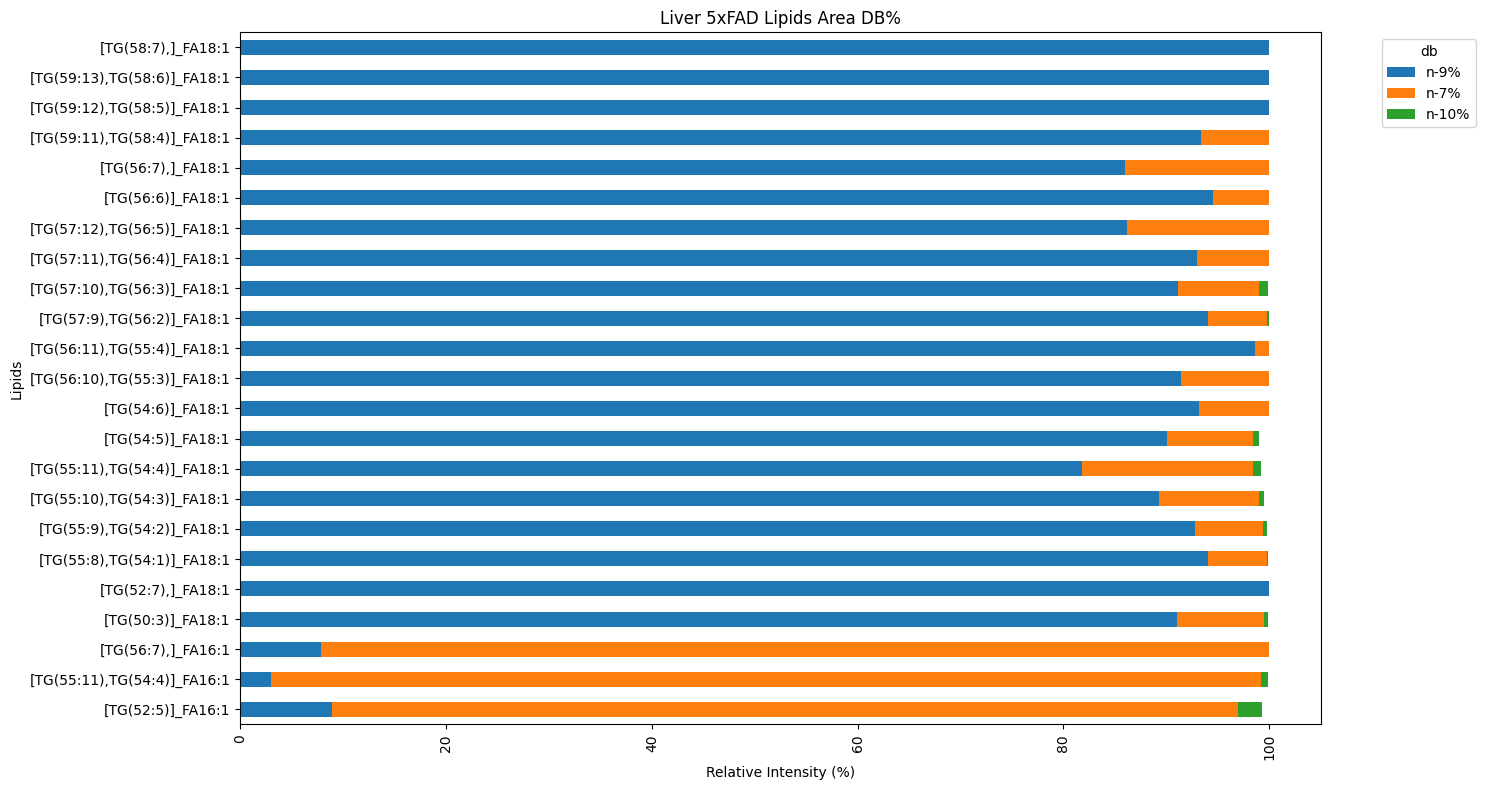

In [42]:
# Reshaping the DataFrame
reshaped_df = df_liver3.melt(id_vars='Lipid', value_vars=['n-7%', 'n-9%', 'n-10%', 'n-12%'], var_name='db', value_name='Percentage')


reshaped_df = reshaped_df[~reshaped_df['Lipid'].str.contains('FA18:2')]

reshaped_df


# Creating a pivot table
pivot_df = reshaped_df.pivot_table(index='Lipid', columns='db', values='Percentage', aggfunc='sum')


# Function to generate a combined sorting key
def combined_sort_key(lipid):
    # Check if lipid contains 'FA16:1'
    fa16_1_key = '0' if 'FA16:1' in lipid else '1'  # '0' for FA16:1, '1' otherwise

    # Extract and sort TG values
    tg_list = re.findall(r'TG\(\d+:\d+\)', lipid)
    tg_list_sorted = ', '.join(sorted(tg_list, key=lambda x: [int(i) for i in x[3:-1].split(':')]))

    # Combine the keys
    return fa16_1_key + tg_list_sorted + lipid

# Apply the combined sorting function to the Lipid index to create a sorting key
pivot_df['Combined_Sort_Key'] = pivot_df.index.to_series().apply(combined_sort_key)

# Sort the DataFrame by the combined sorting key
pivot_df = pivot_df.sort_values(by='Combined_Sort_Key')

# Drop the combined sorting key column
pivot_df.drop('Combined_Sort_Key', axis=1, inplace=True)

# Reordering the columns to make n-9% appear first
# column_order = ['n-9%', 'n-7%', 'n-10%', 'n-12%']
column_order = ['n-9%', 'n-7%', 'n-10%']
pivot_df = pivot_df[column_order]
#delete FA18:2

pivot_df
# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
pivot_df.plot(kind='barh', stacked=True, ax=ax)

ax.set_xlabel('Relative Intensity (%)')
ax.set_ylabel('Lipids')
ax.set_title('Liver 5xFAD Lipids Area DB%')
plt.xticks(rotation=90)

# Moving the legend outside of the plot
ax.legend(title='db', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Saving the plot as a PNG file
# plt.savefig('Barstack_area/Liver_5xFAD_Area.png', dpi=300, bbox_inches='tight')
# #save as pdf
# plt.savefig('Barstack_area/Liver_5xFAD_Area.pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()
